<div>
<img src="figures/svtLogo.png"/>
</div>
<h1><center>Mathematical Optimization for Engineers</center></h1>
<h2><center>Lab 12 - Direct single shooting</center></h2>

$\newcommand{\ddt}[1]{\frac{d#1}{dt}\Bigr \rvert_{t}}$
In this exercise, we want to solve the van der Pol oscillator optimal control problem using the direct single shooting approach. 
The problem without state constraints is as follows: 
$\begin{align}
\min_{u(t)} \int_{t_{0}}^{t_{f}} &x_1^2(t) + x_2^{2}(t) + u(t)^2 dt\\
s.t.  \ddt{x_1} &= x_2(t),\quad t\in [t_0,t_f] \label{eq:vdp_a} \\
\ddt{x_2}&= (1-(x_1(t))^2)\cdot x_2(t) - x_1(t) + u(t),\quad t\in [t_0,t_f], \label{eq:vdp_b} \\
\ddt{x_3} &= ({x_1}(t))^2 + ({x_2}(t))^2+ (u(t))^2 \quad t\in [t_0,t_f] \\
\mathbf{x}(t_{0}) &= \left[0.0, 1.0, 0.0 \right]^{T} \\
-0.3 &\leq u(t) \leq 1.0 \quad \forall t \in [t_{0},t_{f}]\\
\end{align}
$
Note that the objective function value can be determined from the value of the state $x_{3}$ and that $t_{f}=5$.
For direct single shooting, the differential equations are solved by an integration scheme, which is needed to be set-up. 


In [4]:
import numpy as np

from scipy.integrate import odeint, solve_ivp

from scipy.optimize import fmin,fmin_bfgs, Bounds, minimize, NonlinearConstraint

from matplotlib import pyplot as plt
from matplotlib import animation

In [11]:
def eval_rhs(t, x, u, p):
    
    f = np.array([
        x[1],
        (1-x[0]**2)*x[1] - x[0] + u,
        x[0]**2 + x[1]**2 + u**2
    ])
    
    return f

In [14]:
def objective_ode_integration(p, func, x0, finalTime, output_state,
                              is_path_constraint, doPlot):
    # inputs are as follows
    # p = parameter vector of control discretization
    # func: right-hand side of ODE f(t, x, u, p)
    # x0 = initial condition
    # finalTime = tN
    # doPlot = boolean variable, if true, plot solution   

    N = len(p) # Number of discretization intervals
    h = finalTime /N # length of a single interval
    n_x = len(x0)  # number of states
    x0_cur = x0
    y_all = np.array([x0]).transpose() 
    t_all = np.array([0])
    output = list()

    for i in range(N): # loop over discretization intervals
        
        # solve initial value problem
        sol = solve_ivp(func, t_span=[i * h, (i + 1) * h], y0=x0_cur, t_eval=np.linspace(i*h, (i+1)*h, 100), args=(p[i], 0.0))
        
        # update initial conditions
        y = sol.y
        x0_cur = sol.y[0:n_x, -1]
        

        y_all = np.concatenate((y_all, sol.y), axis=1)
        t_all = np.concatenate((t_all, sol.t), axis=0)
        output.append(y[output_state, -1])



    if doPlot:
        y_all = np.array(y_all)
        plt.subplot(221)
        plt.plot(t_all, y_all[0, :])
        plt.title('x1')

        plt.subplot(222)
        plt.plot(t_all, y_all[1, :])
        plt.title('x2')

        plt.subplot(223)
        plt.plot(t_all, y_all[2, :])
        plt.title('x3')
        #
        plt.subplot(224)
        plt.plot(np.linspace(0, finalTime, N), p)
        plt.title('u')

        plt.tight_layout()
        plt.show()
        
    if not is_path_constraint: 
        output = output[-1]
    else:
        # constraint hard coded here to allow for 
        # constraint definition with arguments
        # in scipy, c(x) >= 0
        output = np.array(output) + 0.4

    return output

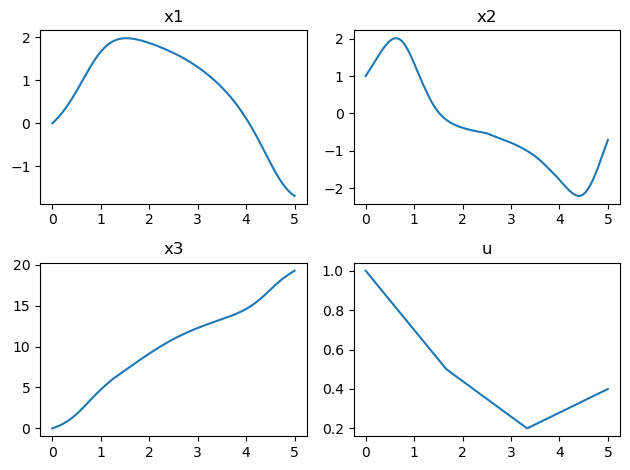

array([], dtype=float64)

In [15]:
objective_ode_integration([1.0, 0.5, 0.2, 0.4], eval_rhs, [0, 1, 0], 5, [], [], True)

  NIT    FC           OBJFUN            GNORM
    1    27     1.302433E+01     4.540690E+00
    2    53     8.554800E+00     4.086918E+00
    3    79     7.908284E+00     3.922266E+00
    4   105     7.035978E+00     3.705334E+00
    5   131     6.917784E+00     3.055133E+00
    6   157     6.912748E+00     2.590765E+00
    7   183     6.912450E+00     2.534530E+00
    8   209     6.912365E+00     2.539583E+00
    9   235     6.912360E+00     2.544780E+00
   10   260     6.912360E+00     2.544063E+00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.912359787293161
            Iterations: 10
            Function evaluations: 260
            Gradient evaluations: 10
     fun: 6.912359787293161
     jac: array([ 1.47032899e+00,  1.28741074e+00,  1.08143556e+00,  8.65566134e-01,
        6.49185717e-01,  4.37958241e-01,  2.34635532e-01,  4.14299965e-02,
        3.85046005e-04,  3.53455544e-04,  7.98702240e-05, -2.36214995e-02,
       -9.73829031e-0

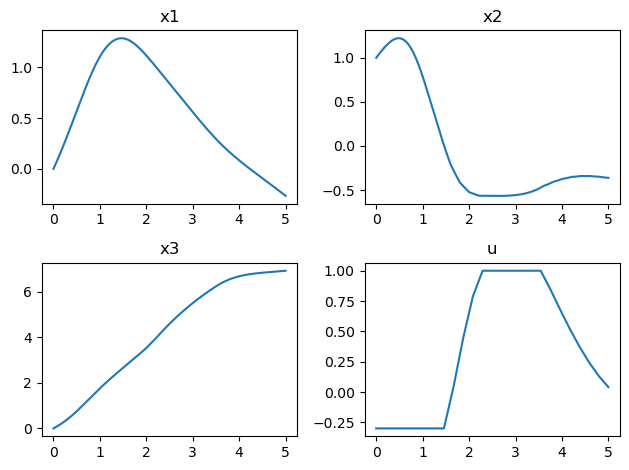

array([], dtype=float64)

In [19]:
finalTime = 5
N = 25 # Number of discretization intervals for the control
doPlot = False
p0 = 1.0*np.ones(N) # initial guess for optimization
x0 = [0, 1, 0]

bnds = Bounds(-0.3, 1.0)

# define objective
output_state = 2  # for objective
is_path_constraint = False
# call optimization with arguments 
# 'eval_rhs, x0, finalTime, output_state, is_path_constraint, doPlot'
solDO = minimize(objective_ode_integration, p0, \
             args=(eval_rhs, x0, finalTime, output_state, is_path_constraint, doPlot), 
              bounds = bnds, method='SLSQP', jac=None, 
                 options={'iprint':3, 'disp': True})
print(solDO)

# call ODE integration to plot trajectories with optimal solution of controls
objective_ode_integration(solDO.x, eval_rhs, [0, 1, 0], 5, [], [], True)


## Adding state path constraint
After solvindg the problem without state constraints, we want to include the path constraint on the state $x_1$:
$ \begin{align}
x_1(t) \geq - 0.4 \forall t \in [t_{0},t_{f}]
\end{align}$
For this task, we must add this constraint to the optimization problem. One way is to define the constraint function as constraint dictionary in Python. 

  NIT    FC           OBJFUN            GNORM
    1    27     1.062433E+01     4.540690E+00
    2    53     8.150909E+00     4.355808E+00
    3    79     7.265145E+00     2.472072E+00
    4   106     6.990335E+00     2.365213E+00
    5   132     6.973140E+00     2.720211E+00
    6   158     6.920885E+00     2.712035E+00
    7   184     6.914211E+00     2.615477E+00
    8   210     6.912696E+00     2.553957E+00
    9   236     6.912436E+00     2.542566E+00
   10   262     6.912372E+00     2.540426E+00
   11   288     6.912361E+00     2.542055E+00
   12   314     6.912360E+00     2.543526E+00
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.912359734268245
            Iterations: 12
            Function evaluations: 314
            Gradient evaluations: 12


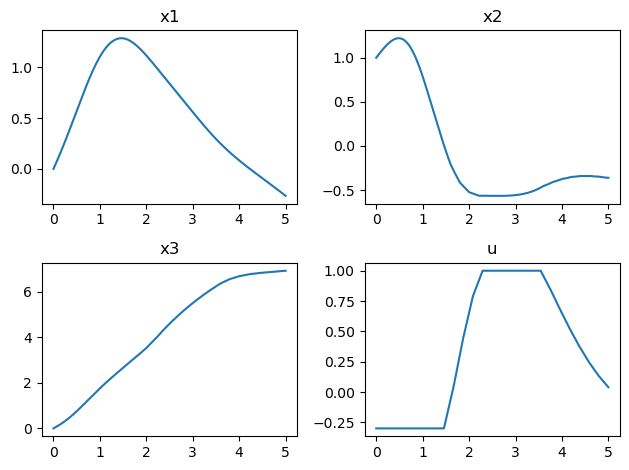

array([], dtype=float64)

In [20]:
# in scipy, the inequality constraints are defined as
# c(x) >= 0 
cons = ({'type': 'ineq',
       'fun': objective_ode_integration,
       'args': (eval_rhs, x0, finalTime, 0, True, False)       
       })

output_state = 2  # for objective
is_path_constraint = False

# call optimization with arguments 
# 'eval_rhs, x0, finalTime, output_state, is_path_constraint, doPlot'
solDO = minimize(objective_ode_integration, p0, \
             args=(eval_rhs, x0, finalTime, output_state, is_path_constraint, doPlot), 
              bounds = bnds, method='SLSQP', jac=None, constraints=cons, 
                 options={'iprint':3, 'disp': True})


# call ODE integration to plot trajectories with optimal solution of controls
objective_ode_integration(solDO.x, eval_rhs, [0, 1, 0], 5, [], [], True)

## What could be made more efficient for this optimization? 